### Feature Selection

In this section we will continute data preprocessing steps in order to facilitate feature selection critera

In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

In [311]:
# read in full netflix dataset (2019 - 2022)
netflix = pd.read_csv("netflix_Cleaned_Data.csv")

In [312]:
# Change "date" column to ensure datetime type and drop weekends
netflix["date"] = pd.to_datetime(netflix["date"])

In [313]:
# Drop first 14 dates
df = netflix.iloc[14:-1, :].reset_index(drop = True)
df.shape

(800, 165)

In [351]:
# Remove any infinitly large or small values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [352]:
# Drop remanining NaN or null values
df = df.dropna()
df.shape

(721, 165)

In [353]:
# Create X feature dataset
X = df.drop(["date", "target_1", "target_2", "target_3", "target_4", "target_5"], axis=1)

# Create y target dataset
y = df["target_1"]

In [379]:
# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

### Lasso Regression

Use lasso regression to find which features have coefficeints significantly different than zero. Those that are should be considered for inclusion in the models

In [382]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

search = GridSearchCV(pipeline,
                       {'model__alpha': np.arange(0.1, 10, 0.1)},
                        cv=10,
scoring = 'neg_mean_squared_error', verbose = 3
)

search.fit(X_scaled, y_scaled)
search.best_params_

coefficients = search.best_estimator_.named_steps['model'].coef_

importance = np.abs(coefficients)
importance

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV 1/10] END ................model__alpha=0.1;, score=-1.003 total time=   0.0s
[CV 2/10] END ................model__alpha=0.1;, score=-0.978 total time=   0.0s
[CV 3/10] END ................model__alpha=0.1;, score=-1.006 total time=   0.0s
[CV 4/10] END ................model__alpha=0.1;, score=-1.006 total time=   0.0s
[CV 5/10] END ................model__alpha=0.1;, score=-0.983 total time=   0.0s
[CV 6/10] END ................model__alpha=0.1;, score=-0.978 total time=   0.0s
[CV 7/10] END ................model__alpha=0.1;, score=-1.052 total time=   0.0s
[CV 8/10] END ................model__alpha=0.1;, score=-0.988 total time=   0.0s
[CV 9/10] END ................model__alpha=0.1;, score=-0.988 total time=   0.0s
[CV 10/10] END ...............model__alpha=0.1;, score=-1.052 total time=   0.0s
[CV 1/10] END ................model__alpha=0.2;, score=-1.003 total time=   0.0s
[CV 2/10] END ................model__alpha=0.2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

### SelectKBest 

In [383]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
best_fit = bestfeatures.fit(X_scaled, y_scaled)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(X.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score']  # naming the dataframe columns
print(features_score.nlargest(10, 'Score'))  # print the top 10 best features

            Features     Score
72         Google_rs  5.934917
154  Dow_MAvg_s_Move  5.384987
94        Stock_gain  4.871434
9             Volume  4.267167
147         Dow_loss  4.251476
145         Dow_diff  4.011803
60     Google_MAvg_s  3.952984
59       Google_MAvg  3.674967
66        Google_EMA  3.370811
48         Wiki_Move  3.083387


C:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


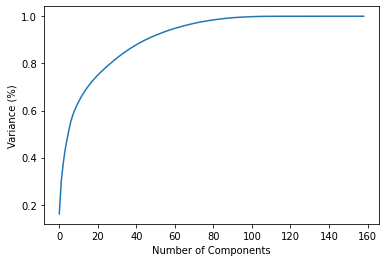

In [368]:
pca = PCA().fit(X_scaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()